In [1]:
from tope import Tope
from tope.net import *
from tope.orth import *
from tests import normalize_polygon

import json, os, numpy as np
rng = np.random.default_rng()
with open("polys.json") as fd: polys = json.load(fd)

In [2]:
v_24cell = [
    [1, 0, 0, 0], [-1, 0, 0, 0],
    [0, 1, 0, 0], [0, -1, 0, 0],
    [0, 0, 1, 0], [0, 0, -1, 0], 
    [0, 0, 0, 1], [0, 0, 0, -1],
    [1, -1, 0, 0], [-1, 1, 0, 0], 
    [1, 0, -1, 0], [-1, 0, 1, 0], 
    [1, 0, 0, -1], [-1, 0, 0, 1], 
    [0, 1, -1, 0], [0, -1, 1, 0], 
    [0, 1, 0, -1], [0, -1, 0, 1],
    [1, 0, -1, -1], [-1, 0, 1, 1], 
    [0, 1, -1, -1], [0, -1, 1, 1],
    [1, 1, -1, -1], [-1, -1, 1, 1]
]

In [3]:
EdgeList = list[np.ndarray] # list of 2xdim arrays

def get_cuts(N: Net) -> EdgeList:
    return np.concatenate([N.tope.metadata[2][i]["cuts"] for i in range(len(N.facets))])
        
        
def get_edges(N: Net) -> EdgeList: # apply to unfolded Net
    edges = []
    for i, vertices in N.facets.items():
        facet_template = N.tope.get_face(i) # has correct indices
        edges.extend((vertices[list(e)] for e in facet_template.faces[1]))
    return edges

FacetLabels = list[tuple[str, np.ndarray]]

def get_facet_labels(N: Net) -> FacetLabels:
    labels = []
    for i, vertices in N.facets.items():
        labels.append((N.tope.metadata[-1][i]["index"], vertices.mean(axis=0)))
    return labels

In [4]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection # container for line segments
from matplotlib.text import Text, Annotation
import matplotlib.cm as cm # colour mappings
import random

In [5]:
def get_net_for_facet(P: Tope, i: int) -> Net:
    F = P.get_facet(i, metadata_keys=["cuts"])
    G = get_facet_graph(F)
    T = G.get_spanning_tree()
    N = Net(F, T).unfold_with_metadata(meta_keys = ["cuts"]).in_own_span(meta_keys=["cuts"])
    return N

In [15]:
MARGIN_FACTOR = 1.1

def save_nets(P: Tope, name: str, margin_factor: float = MARGIN_FACTOR, dpi: int = 300, force=False):
    if os.path.exists(name):
        if force:
            if os.path.isdir(name):
                logger.warning("Directory already exists. Writing anyway.")
            else:
                logger.error("File already exists and is not a directory. Aborting")
                return
        else:
            logger.error("File already exists. Aborting.")
            return
    else:
        os.mkdir(name)
    
    nfacets = len(P.faces[-1])
    facet_net_list = []
    
    xlim = [0,0]
    ylim = [0,0]

    for i in range(nfacets):
        N = get_net_for_facet(P, i)
        for face_v in N.facets.values():
            lower, upper = face_v.min(axis=0), face_v.max(axis=0)
            xlim[0] = min(xlim[0], lower[0])
            ylim[0] = min(ylim[0], lower[1])
            xlim[1] = max(xlim[1], upper[0])
            ylim[1] = max(ylim[1], upper[1])
        facet_net_list.append(N)
        
    xlim[0] *= margin_factor
    ylim[0] *= margin_factor
    xlim[1] *= margin_factor
    ylim[1] *= margin_factor
        
    for i in range(len(P.faces[-1])):
        fig, ax = plt.subplots()
        N = facet_net_list[i]
        lc = LineCollection(get_edges(N), colors="grey", linewidths=0.2)
        cuts = LineCollection(get_cuts(N), colors="#c0c7e1", linewidths=0.1)
        ax.add_collection(lc)
#        ax.add_collection(cuts)
        for label, pos in get_facet_labels(N):
            ax.add_artist(Text(pos[0], pos[1], text=str(label), fontsize=2, ha="center", va="center"))
        
        # inset title in root face
        title_pos = N.facets[N.tree.root].mean(axis=0) + [0,-.4]
        ax.add_artist(Text(*title_pos, text=f"{name}\n(facet {i})", fontsize=2, ha="center", va="center"))

        ax.set_title(f"{name}-facet-{i}", y=1.0, pad=-14, fontsize=8)
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        ax.set_aspect(1)
        
        fname = os.path.join(name, f"{i}.png")
        if force and os.path.exists(fname):
            logger.warning(f"Overwriting existing file {fname}.")
            try:
                os.unlink(fname)
            except OSError as err: # perhaps fname is a directory or we don't have the right permissions
                logger.error(str(err))
                return
        fig.savefig(fname, dpi=dpi)

In [ ]:
hyperplanes = [H for L in [
    (np.array([1,0,0,0]), np.array([1,0,0,0])), 
    (np.array([0,1,0,0]), np.array([0,1,0,0])),
    (np.array([0,0,1,0]), np.array([0,0,1,0])),
    (np.array([0,0,0,1]), np.array([0,0,0,1]))
] for H in [
    (L[0], i * L[1]) for i in np.arange(-1, 1, 0.2)
]]

<ipython-input-15-8a520285b55f>:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


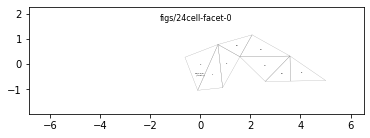

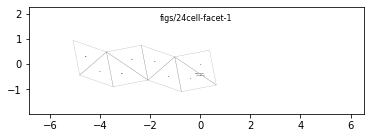

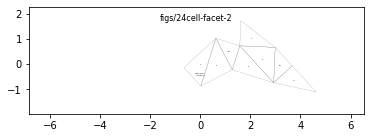

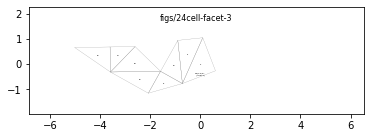

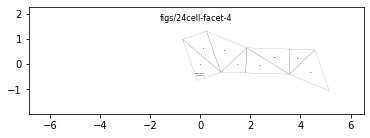

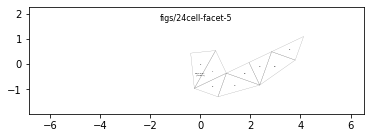

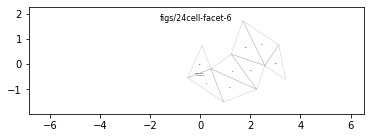

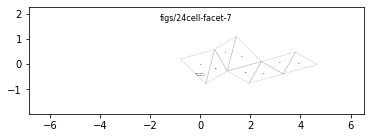

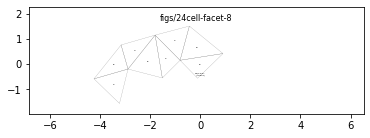

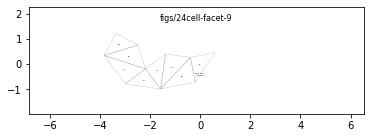

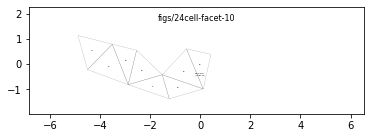

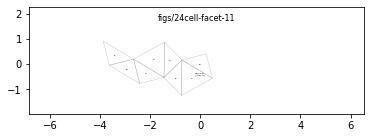

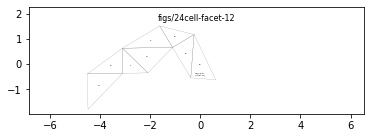

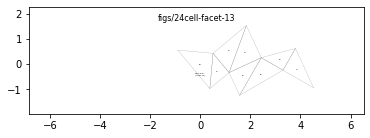

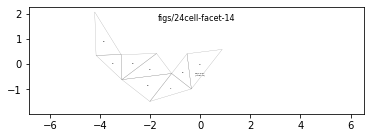

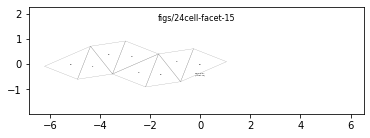

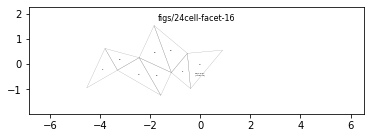

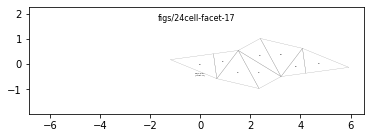

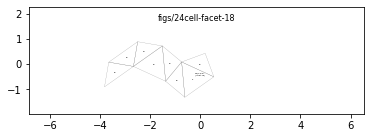

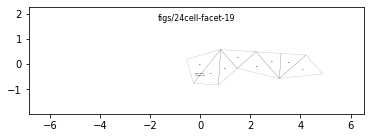

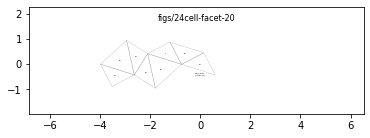

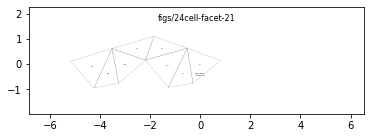

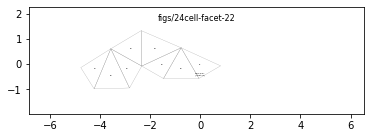

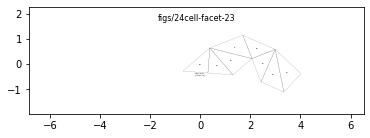

In [16]:
P = Tope.from_vertices(v_24cell)
P.save_index() # now must do this before passing to sub-topes
P.cut_2faces_with_hyperplanes(hyperplanes) # and this
save_nets(P, "figs/24cell", force=True)

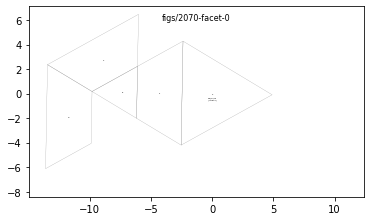

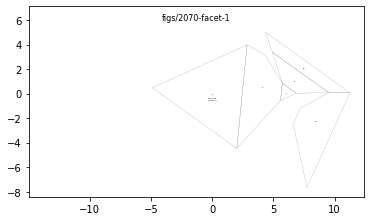

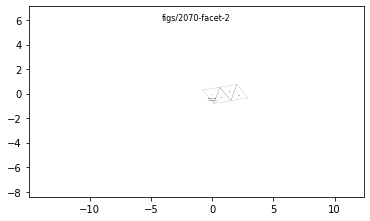

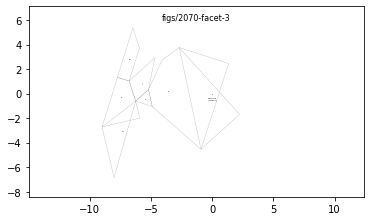

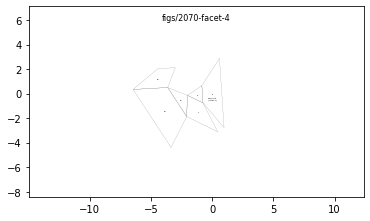

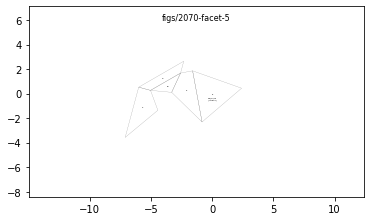

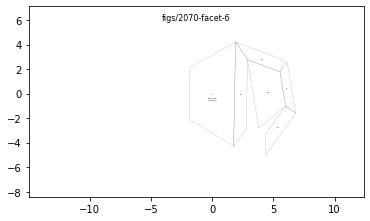

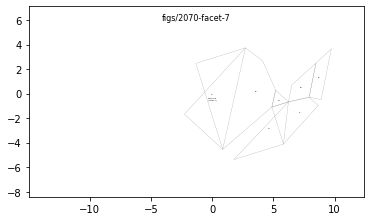

In [20]:
P = Tope.from_vertices(polys["2070"])
P.save_index() # now must do this before passing to sub-topes
P.cut_2faces_with_hyperplanes([]) # and this
save_nets(P, "figs/2070", force=True)

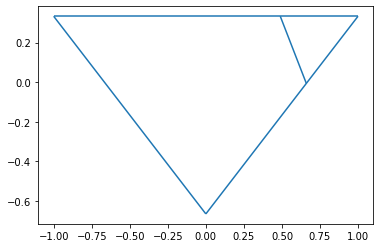

In [43]:
# sanity check

P = Tope.from_vertices(v_24cell)
P.save_index() # now must do this before passing to sub-topes
P.cut_2faces_with_hyperplanes([(rng.normal(size=4), np.zeros(4)) for _ in range(1)]) # and this
#n = get_net_for_facet(P, 0)
#save_nets(P, "figs/24cell", force=True)
F = P.get_face(0,2)

origin = F.vertices.mean(axis=0)
v, basis = in_own_span(F.vertices-origin)
F1 = Tope(v, F.faces, F.metadata)
P.apply_to(lambda x : (x-origin)@basis.T, "cuts")

fig, ax = plt.subplots()
lc = LineCollection([F1.vertices[[0,1]], F1.vertices[[1,2]], F1.vertices[[2,0]], P.metadata[2][0]["cuts"][0]])
ax.add_collection(lc)
ax.autoscale()

In [ ]:
#save_nets(Tope.from_vertices(polys["2070"]), "figs/2070", force=True)

In [ ]:
for name, poly in polys.items():
    save_nets(Tope.from_vertices(poly), f"figs/{name}", force=True)

In [3]:
with open("../polys1.json") as fd: data = json.load(fd)

In [ ]:
#ID = ""
for _ in range(10):
    k, v = data.popitem()
    P = Tope.from_vertices(v)
    if len(P.faces[-1]) < 25: continue
    save_nets(P, f"figs/{k}")

In [4]:
for k, v in data.items():
    P = Tope.from_vertices(v)
    if len(P.faces[-1]) > 24:
        print(k)

192153
250561
1206449
1226247
1736917
2347951
2349369
3107341
4815325
4902603
4622417
4846643
5042497
5042793
5055703
5127949
5560559
5792367
5919509
6155705
6390055
2642627
2761299
2865097
3328185
4499777
5055429
5239323
1135827
1347389
1554743
2589049
2862713
2347811
2474007
561637
668671
2906037
3034405
4496469
4694845
5013575
1206731
3723609
5797129
4615417
4829339
5131537
2471227
2514727
2590101
2772257
2904929
2864749
3252051
4894261
4497119
4695067
4904951
6147783
1158915
4496259
4694113
5469045
5493895
5994655
2387203
1226255
1369835
3032013
2337333
2348413
2470937
2865395
3034831
4496789
4696385
4903271
5044393
5494155
4622443
5260719


KeyboardInterrupt: 

In [ ]:
from random import choice

In [ ]:
data.popitem()